In [1]:
import pandas as pd
import geopandas as gpd
import folium
#import keplergl as kp
import partridge as ptg

In [2]:
# Insert the path to your GTFS folder
# Example: '/Users/santiagotoso/MBTA Remix GTFS - All patterns'


#fp = '/Users/santiagotoso/Downloads/GTFS-TRIPS_c0edf68_2019-12-13-22-55-03'

In [3]:
# Partridge to read the feed

service_ids = ptg.read_busiest_date(r"C:\Users\santi\Google Drive\Master\Python\Turku\GTFS-TRIPS_e6b8273_2020-02-28-14-22-32")[1]
view = {'trips.txt': {'service_id': service_ids}}

feed = ptg.load_geo_feed(r"C:\Users\santi\Google Drive\Master\Python\Turku\GTFS-TRIPS_e6b8273_2020-02-28-14-22-32")

routes = feed.routes
trips = feed.trips
stop_times = feed.stop_times
stops = feed.stops
gdf = feed.shapes #should change this in the rest of the notebook

shapes = feed.shapes

In [4]:
# Get routes info in trips
trips = pd.merge(trips, routes, how='left').loc[:, ['trip_id', 'route_id', 
                                                    'service_id', 'direction_id', 'shape_id']]

# Get trips, routes and stops info in stop_times
stop_times = pd.merge(stop_times, trips, how='left') 
stop_times = pd.merge(stop_times, stops, how='left')
stop_times.head(1)

,trip_id,stop_id,stop_sequence,arrival_time,departure_time,timepoint,route_id,service_id,direction_id,shape_id,stop_name,geometry
0,1,1651,1,19200.0,19200.0,1,0209fb0,2,1,640692339,Kohmo,POINT (22.35103 60.45837)


In [5]:
# Data frame with stop sequence for route and direction
sseq = stop_times.pivot_table('stop_sequence',
                                     index = ['route_id', 'direction_id', 
                                              'stop_id','stop_name', 'shape_id'],
                                     aggfunc='mean').sort_values(by=[
    'shape_id','route_id', 'direction_id', 'stop_sequence', 'stop_id']).reset_index()

sseq.head(3)

,route_id,direction_id,stop_id,stop_name,shape_id,stop_sequence
0,65a9979,0,1708,Katariina,640691799,1.0
1,65a9979,0,1707,Katariinakoti,640691799,2.0
2,65a9979,0,515,Ilpoistenrinne,640691799,3.0


In [6]:
route_shapes = sseq.pivot_table('stop_id',
                               index = ['route_id', 'direction_id', 'shape_id'],
                               aggfunc='count').reset_index()
route_shapes.columns = ['route_id', 'direction_id', 'shape_id', 'stops_count']
route_shapes.head(3)

,route_id,direction_id,shape_id,stops_count
0,0209fb0,0,640692338,36
1,0209fb0,1,640692339,37
2,0209fb0,1,640692340,19


In [7]:
from shapely.ops import nearest_points

# Create a DataFrame with the pair (stop, nearest_point) for each shape_id

shape_closest_points = pd.DataFrame()

for index, row in gdf.iterrows():
    shape_id = row.shape_id
    route_id = route_shapes.loc[route_shapes.shape_id == shape_id, 'route_id'].values[0]
    direction_id = route_shapes.loc[route_shapes.shape_id == shape_id, 'direction_id'].values[0]
    
    # Look for the shape
    shape = gdf.loc[gdf.shape_id == shape_id,'geometry'].values[0]

    
    # Look for the stop_ids of this shape
    route_stop_ids = sseq.loc[(sseq['route_id'] == route_id) 
                              & (sseq['direction_id'] == direction_id)
                              &(sseq['shape_id'] == shape_id)]

    # Look for the geometry of these stops
    merged = pd.merge(route_stop_ids, stops, left_on='stop_id', right_on='stop_id', how='left')
    route_stop_geom = merged.geometry
    
    # Look for the nearest points of these stops that are in the shape
    points_in_shape = route_stop_geom.apply(lambda x: nearest_points(x, shape))
   
    # Append to DataFrame
    appendable = pd.DataFrame()
    appendable['points'] = points_in_shape
    appendable['shape_id'] = shape_id
    
    shape_closest_points = shape_closest_points.append(appendable)
    
shape_closest_points.head(1)

,points,shape_id
0,"(POINT (22.288812 60.41308000000001), POINT (2...",640691799


In [69]:
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString, MultiLineString

shape_trans_lines = pd.DataFrame()
# First we define a function that will help us create the line to intersect the shape
offset = 0.0001

def create_line(row):
    # Formula to make the line longer
    # a = (y1-b)/x1
    # b = (y2-x2/x1*y1)/(1-x2/x1)
    if row[0] == row[1]:
        x1 = row[0].x - offset
        y1 = row[0].y - offset
        
        x2 = row[0].x 
        y2 = row[0].y
        
        x3 = row[0].x + offset
        y3 = row[0].y + offset
        
    else:   
        x1 = row[0].x
        y1 = row[0].y

        x2 = row[1].x
        y2 = row[1].y

        # If x2==x1 it will give the error "ZeroDivisionError"
        if float(x2) != float(x1):
            b = (y2-x2/x1*y1)/(1-x2/x1)
            a = (y1-b)/x1

            if x2 - x1 < 0: # We should create an "if" to check if we need to do -1 or +1 depending on x2-x1
                x3 = x2 - offset
            else:
                x3 = x2 + offset

            y3 = a*x3 + b

        else:
            x3 = x2
            b = 0
            a = 0

            if y2-y1 < 0:
                y3 = y2 - offset/5
            else: 
                y3 = y2 + offset/5

    trans = LineString([Point(x1,y1), Point(x2,y2), Point(x3, y3)])
    return trans

# For each shape we need to create transversal lines and separete the shape in segments
for index, row in gdf.iterrows():
    # Choose the shape
    shape_id = row.shape_id
    
    # Choose the pair (stop, nearest point to shape) to create the line
    scp = shape_closest_points.loc[shape_closest_points.shape_id == shape_id, 'points']
    
    lines = scp.apply(create_line)
    lines_gdf = gpd.GeoDataFrame(geometry=lines)
    lines_multi = MultiLineString(list(lines.values)[1:-1])
    
    appendable = pd.DataFrame()
    appendable['trans_lines'] = lines
    appendable['shape_id'] = shape_id
    
    shape_trans_lines = shape_trans_lines.append(appendable)
    
shape_trans_lines.head(3)

,trans_lines,shape_id
0,"LINESTRING (22.288712 60.41298, 22.288812 60.4...",640691799
1,"LINESTRING (22.290148 60.41535999999999, 22.29...",640691799
2,"LINESTRING (22.282987 60.415097, 22.283087 60....",640691799


In [62]:
test = shape_trans_lines.loc[shape_trans_lines.shape_id=='640692261','trans_lines']

test = gpd.GeoSeries(test)


# import keplergl as kp

m = kp.KeplerGl(height=600)
m.add_data(data=test[47].__geo_interface__, name='lines')
# m.add_data(data=nearest_test.__geo_interface__, name='nearest points')
m

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'lines': {'type': 'LineString', 'coordinates': ((22.276417, 60.451381), (22.276426999999998, 60…

In [70]:
shape_trans_lines.loc[shape_trans_lines.trans_lines.isnull()]

,trans_lines,shape_id


Assumptions to cut the shape in segments:

1. There one stop at beginning of the shape and one stop at the end of the shape.
2. 

In [71]:
from shapely.ops import split
from shapely import geometry, ops

# Set the tolerance of the cuts
tolerance = 0.0001

segments = pd.DataFrame()

for index, row in gdf.iterrows():
    shape_id = row.shape_id
    route_id = route_shapes.loc[route_shapes.shape_id == shape_id, 'route_id'].values[0]
    direction_id = route_shapes.loc[route_shapes.shape_id == shape_id, 'direction_id'].values[0]
    
    df = sseq.loc[(sseq['route_id'] == route_id) 
                  & (sseq['direction_id'] == direction_id)
                  & (sseq['shape_id'] == shape_id)].reset_index()
    
    df['segment'] = ''
    
    # Split the shape in different segments
    line = gdf.loc[gdf.shape_id == shape_id, 'geometry'].values[0]
    trans_lines = shape_trans_lines.loc[shape_trans_lines.shape_id == shape_id, 'trans_lines']
    
    if len(trans_lines) == 2:
        # In case there is a line with only two stops
        df.loc[0, 'segment']  = line
        segments = segments.append(df)
    else:
        trans_lines_all = MultiLineString(list(trans_lines.values))
        trans_lines_cut = MultiLineString(list(trans_lines.values)[1:-1])

        # Split the shape in different segments, cut by the linestrings created before
        # The result is a geometry collection with the segments of the route
        result = split(line, trans_lines_cut)

        j = 0
        try: 
            if len(result)==len(trans_lines_all)-1:
                for i in range(0, len(result)):
                    df.loc[i, 'segment'] = result[i] 
                segments = segments.append(df)
            else:
                for i in range(0, len(df)-1):
                    #p = result[j].intersects(trans_lines_all[i])*result[j].intersects(trans_lines_all[i+1])     
                    p = result[j].distance(trans_lines_all[i]) + result[j].distance(trans_lines_all[i+1]) 
                    #if p==1:
                    if p < tolerance:
                        df.loc[i, 'segment'] = result[j]
                        j+=1
                    else:

                        #multi_line = result[j]
                        points = []
                        points.extend(result[j].coords)
                        while p > tolerance:
                            # combine them into a multi-linestring
                            j+=1
                            points.extend(result[j].coords)
                            merged_line = geometry.LineString(points)

                            #multi_line = geometry.MultiLineString([multi_line, result[j]])
                            #merged_line = ops.linemerge(multi_line)
                            p = merged_line.distance(trans_lines_all[i]) + merged_line.distance(trans_lines_all[i+1])
                            if p < tolerance:
                                j+=1

                        df.loc[i, 'segment'] = merged_line
                # deberia meter un if que verifique si j == len(result)-1. si el resultado es si, seguimos
                # si el resultado es no, agrego todos los result que queden en el ultimo segmento de df (df[len(df)-1])
                if j < len(result)-1:
                    points = []
                    for r in range(j, len(result)-1):
                        points.extend(result[r].coords)

                    merged_line = geometry.LineString(points)
                    df.loc[len(df)-1, 'segment'] = merged_line

                segments = segments.append(df)

        except IndexError:
            continue

segments.head(1)

,index,route_id,direction_id,stop_id,stop_name,shape_id,stop_sequence,segment
0,0,65a9979,0,1708,Katariina,640691799,1.0,"LINESTRING (22.288812 60.41308000000001, 22.28..."


In [73]:
osm_style = gpd.GeoDataFrame()

for index, row in gdf.iterrows():
    shape_id = row.shape_id
    df = segments.loc[segments.shape_id==shape_id,:].reset_index()
    s = df['stop_id']
    s_name = df['stop_name']
    df['end_stop_id'] = ''
    df['end_stop_name'] = ''
    
    for i in range(0, len(df)-1):
        df.loc[i, 'end_stop_id'] = s.iloc[i+1]
        df.loc[i, 'end_stop_name'] = s_name.iloc[i+1]
        
    osm_style = osm_style.append(df)
    
osm_style = osm_style.loc[:,['route_id', 'direction_id', 'stop_sequence',
                             'stop_id', 'stop_name', 'end_stop_id',
                             'end_stop_name', 'shape_id', 'segment']]

osm_style.columns = ['route_id', 'direction_id', 'stop_sequence',
                     'start_stop_id', 'start_stop_name', 'end_stop_id',
                     'end_stop_name', 'shape_id', 'segment']

osm_style.head()

,route_id,direction_id,stop_sequence,start_stop_id,start_stop_name,end_stop_id,end_stop_name,shape_id,segment
0,65a9979,0,1.0,1708,Katariina,1707,Katariinakoti,640691799,"LINESTRING (22.288812 60.41308000000001, 22.28..."
1,65a9979,0,2.0,1707,Katariinakoti,515,Ilpoistenrinne,640691799,LINESTRING (22.29019241411043 60.4154044141104...
2,65a9979,0,3.0,515,Ilpoistenrinne,1465,Pulkkavuori,640691799,"LINESTRING (22.283079 60.415123, 22.283087 60...."
3,65a9979,0,4.0,1465,Pulkkavuori,1466,Juhanankatu,640691799,"LINESTRING (22.278302 60.415245, 22.278305 60...."
4,65a9979,0,5.0,1466,Juhanankatu,1705,Rykmentintie,640691799,"LINESTRING (22.273089 60.41505799999999, 22.27..."


In [74]:
osm_style['segment_id'] = osm_style['start_stop_id'] + '_' + osm_style['end_stop_id']
osm_style['segment_name'] = osm_style['start_stop_name'] + ' - ' + osm_style['end_stop_name']
osm_style.head()

,route_id,direction_id,stop_sequence,start_stop_id,start_stop_name,end_stop_id,end_stop_name,shape_id,segment,segment_id,segment_name
0,65a9979,0,1.0,1708,Katariina,1707,Katariinakoti,640691799,"LINESTRING (22.288812 60.41308000000001, 22.28...",1708_1707,Katariina - Katariinakoti
1,65a9979,0,2.0,1707,Katariinakoti,515,Ilpoistenrinne,640691799,LINESTRING (22.29019241411043 60.4154044141104...,1707_515,Katariinakoti - Ilpoistenrinne
2,65a9979,0,3.0,515,Ilpoistenrinne,1465,Pulkkavuori,640691799,"LINESTRING (22.283079 60.415123, 22.283087 60....",515_1465,Ilpoistenrinne - Pulkkavuori
3,65a9979,0,4.0,1465,Pulkkavuori,1466,Juhanankatu,640691799,"LINESTRING (22.278302 60.415245, 22.278305 60....",1465_1466,Pulkkavuori - Juhanankatu
4,65a9979,0,5.0,1466,Juhanankatu,1705,Rykmentintie,640691799,"LINESTRING (22.273089 60.41505799999999, 22.27...",1466_1705,Juhanankatu - Rykmentintie


In [75]:
# Keep in mind that we are filtering out the empty segments
# This means we will have different lengths per shape_id
data = osm_style.loc[osm_style.segment!=''].drop(['segment'], axis=1)
geometry = osm_style.loc[osm_style.segment!='', 'segment']

segments_gdf = gpd.GeoDataFrame(data = data, geometry = geometry)

In [76]:
import utm

segments_gdf.crs= {'epsg:4326'}
segments_gdf.crs

lat = segments_gdf.geometry.iloc[0].coords[0][1]
lon = segments_gdf.geometry.iloc[0].coords[0][0]

zone = utm.from_latlon(lat, lon)

def code(zone):
    #The EPSG code is 32600+zone for positive latitudes and 32700+zone for negatives.
    if lat <0:
        epsg_code = 32700 + zone[2]
    else:
        epsg_code = 32600 + zone[2]
    return epsg_code

#code(zone)

segments_gdf['distance_m'] = segments_gdf.geometry.to_crs(epsg=code(zone)).length

C:\Users\santi\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [77]:
segments_gdf.head()

,route_id,direction_id,stop_sequence,start_stop_id,start_stop_name,end_stop_id,end_stop_name,shape_id,segment_id,segment_name,geometry,distance_m
0,65a9979,0,1.0,1708,Katariina,1707,Katariinakoti,640691799,1708_1707,Katariina - Katariinakoti,"LINESTRING (22.28881 60.41308, 22.28880 60.412...",343.520784
1,65a9979,0,2.0,1707,Katariinakoti,515,Ilpoistenrinne,640691799,1707_515,Katariinakoti - Ilpoistenrinne,"LINESTRING (22.29019 60.41540, 22.29019 60.415...",471.305280
2,65a9979,0,3.0,515,Ilpoistenrinne,1465,Pulkkavuori,640691799,515_1465,Ilpoistenrinne - Pulkkavuori,"LINESTRING (22.28308 60.41512, 22.28309 60.415...",280.660828
3,65a9979,0,4.0,1465,Pulkkavuori,1466,Juhanankatu,640691799,1465_1466,Pulkkavuori - Juhanankatu,"LINESTRING (22.27830 60.41524, 22.27830 60.415...",307.831450
4,65a9979,0,5.0,1466,Juhanankatu,1705,Rykmentintie,640691799,1466_1705,Juhanankatu - Rykmentintie,"LINESTRING (22.27309 60.41506, 22.27308 60.415...",288.893925


# Speed

In [78]:
stop_times.sort_values(by = ['trip_id', 'stop_sequence'], ascending = True, inplace=True)
stop_times.head()

,trip_id,stop_id,stop_sequence,arrival_time,departure_time,timepoint,route_id,service_id,direction_id,shape_id,stop_name,geometry
0,1,1651,1,19200.0,19200.0,1,0209fb0,2,1,640692339,Kohmo,POINT (22.35103 60.45837)
1,1,1652,2,19260.0,19260.0,0,0209fb0,2,1,640692339,Kohmonkuja,POINT (22.34469 60.45755)
2,1,1654,3,19320.0,19320.0,0,0209fb0,2,1,640692339,Kohmontie,POINT (22.33928 60.45765)
3,1,1656,4,19380.0,19380.0,0,0209fb0,2,1,640692339,Jaaninoja,POINT (22.33547 60.45926)
4,1,1658,5,19380.0,19380.0,0,0209fb0,2,1,640692339,Kylämäki,POINT (22.33368 60.46155)


In [79]:
first_try = stop_times.loc[:,['trip_id', 'arrival_time']]
first_try['trip_id_next'] = first_try['trip_id'].shift(-1)
first_try['arrival_time_next'] = first_try['arrival_time'].shift(-1)
first_try.head()

,trip_id,arrival_time,trip_id_next,arrival_time_next
0,1,19200.0,1,19260.0
1,1,19260.0,1,19320.0
2,1,19320.0,1,19380.0
3,1,19380.0,1,19380.0
4,1,19380.0,1,19440.0


In [80]:
def runtime(row):
    if row.trip_id == row.trip_id_next:
        runtime = (row.arrival_time_next - row.arrival_time)/3600
    else:
        runtime = 0
    
    return runtime

first_try['runtime_h'] = first_try.apply(runtime, axis=1)
first_try.head()

,trip_id,arrival_time,trip_id_next,arrival_time_next,runtime_h
0,1,19200.0,1,19260.0,0.016667
1,1,19260.0,1,19320.0,0.016667
2,1,19320.0,1,19380.0,0.016667
3,1,19380.0,1,19380.0,0.000000
4,1,19380.0,1,19440.0,0.016667


In [81]:
len(first_try) == len(stop_times)

True

In [82]:
stop_times['runtime_h'] = first_try['runtime_h']
stop_times.head()

,trip_id,stop_id,stop_sequence,arrival_time,departure_time,timepoint,route_id,service_id,direction_id,shape_id,stop_name,geometry,runtime_h
0,1,1651,1,19200.0,19200.0,1,0209fb0,2,1,640692339,Kohmo,POINT (22.35103 60.45837),0.016667
1,1,1652,2,19260.0,19260.0,0,0209fb0,2,1,640692339,Kohmonkuja,POINT (22.34469 60.45755),0.016667
2,1,1654,3,19320.0,19320.0,0,0209fb0,2,1,640692339,Kohmontie,POINT (22.33928 60.45765),0.016667
3,1,1656,4,19380.0,19380.0,0,0209fb0,2,1,640692339,Jaaninoja,POINT (22.33547 60.45926),0.000000
4,1,1658,5,19380.0,19380.0,0,0209fb0,2,1,640692339,Kylämäki,POINT (22.33368 60.46155),0.016667


In [136]:
# Filter peak from 7 - 9 am and get the average runtime in hours
peak = stop_times.loc[stop_times.arrival_time.between(7*3600, 9*3600),:]

avg_runtimes_df = peak.pivot_table('runtime_h',
                       index = ['route_id', 'direction_id', 'stop_id', 'stop_sequence', 'shape_id'],
                       aggfunc = 'mean').reset_index().sort_values(by=['route_id', 'direction_id', 'stop_sequence']).reset_index()
avg_runtimes_df.drop('index', inplace=True, axis=1)
avg_runtimes_df.head(3)

,route_id,direction_id,stop_id,stop_sequence,shape_id,runtime_h
0,0209fb0,0,1552,1,640692338,0.018667
1,0209fb0,0,1554,2,640692338,0.013667
2,0209fb0,0,1556,3,640692338,0.012000


In [137]:
# Calculate min runtime for all day to keep it fro free-flow
min_runtimes_df = stop_times.pivot_table('runtime_h',
                       index = ['route_id', 'direction_id', 'stop_id', 'stop_sequence', 'shape_id'],
                       aggfunc ='min').reset_index().sort_values(by=['route_id', 'direction_id', 'stop_sequence']).reset_index()
min_runtimes_df.drop('index', inplace=True, axis=1)
min_runtimes_df.head(3)

,route_id,direction_id,stop_id,stop_sequence,shape_id,runtime_h
0,0209fb0,0,1552,1,640692338,0.016667
1,0209fb0,0,1554,2,640692338,0.000000
2,0209fb0,0,1556,3,640692338,0.000000


In [140]:
runtimes_df = pd.merge(
    avg_runtimes_df, min_runtimes_df,
    left_on=['route_id', 'direction_id', 'stop_id', 'stop_sequence', 'shape_id'], 
    right_on=['route_id', 'direction_id', 'stop_id', 'stop_sequence', 'shape_id'],
    how='left'
)

runtimes_df.columns = ['route_id', 'direction_id', 'stop_id', 'stop_sequence', 'shape_id', 'avg_runtime_h', 'min_runtime_h']
runtimes_df.head(2)

,route_id,direction_id,stop_id,stop_sequence,shape_id,avg_runtime_h,min_runtime_h
0,0209fb0,0,1552,1,640692338,0.018667,0.016667
1,0209fb0,0,1554,2,640692338,0.013667,0.000000


In [141]:
segments_gdf['direction_id'] = segments_gdf['direction_id'].map(int)
segments_gdf['stop_sequence'] = segments_gdf['stop_sequence'].map(int)

speeds = pd.merge(segments_gdf, runtimes_df, 
                  left_on = ['route_id', 'direction_id', 'start_stop_id', 'stop_sequence', 'shape_id'],
                  right_on = ['route_id', 'direction_id', 'stop_id', 'stop_sequence', 'shape_id'], 
                  how = 'left').drop('stop_id', axis=1)

speeds.head(1)

,route_id,direction_id,stop_sequence,start_stop_id,start_stop_name,end_stop_id,end_stop_name,shape_id,segment_id,segment_name,geometry,distance_m,avg_runtime_h,min_runtime_h
0,65a9979,0,1,1708,Katariina,1707,Katariinakoti,640691799,1708_1707,Katariina - Katariinakoti,"LINESTRING (22.28881 60.41308, 22.28880 60.412...",343.520784,0.016667,0.016667


In [176]:
# Calculate the speeds for the rows that have a runtime different from 0
speeds['avg_speed'] = 0 
speeds.loc[speeds['avg_runtime_h'] != 0, 'avg_speed'] = round(speeds.loc[speeds['avg_runtime_h'] != 0, 'distance_m']/1000/speeds.loc[speeds['avg_runtime_h'] != 0, 'avg_runtime_h'])

speeds['free_flow'] = 0
speeds.loc[speeds['avg_runtime_h'] != 0, 'free_flow'] = round(speeds.loc[speeds['avg_runtime_h'] != 0, 'distance_m']/1000/speeds.loc[speeds['avg_runtime_h'] != 0, 'min_runtime_h'])

# Assign the average speed to those rows with a runtime == 0
# This brings a problem where free-flow speeds is inf right now
# We will calculate that afterwards
avg_speed = speeds.loc[speeds['avg_runtime_h'] != 0, 'avg_speed'].mean()
avg_ff = speeds.loc[speeds['avg_runtime_h'] != 0, 'free_flow'].mean()

speeds.loc[speeds['avg_runtime_h'] == 0, 'avg_speed'] = round(avg_speed)

# Calculate the differece from free-flow for the one with min runtime != 0
speeds['delta_ff_perc'] = 0
speeds.loc[speeds['avg_runtime_h'] != 0, 'delta_ff_perc'] = round((speeds.loc[speeds['avg_runtime_h'] != 0, 'avg_speed'] - speeds.loc[speeds['avg_runtime_h'] != 0, 'free_flow'])/speeds.loc[speeds['avg_runtime_h'] != 0, 'free_flow'] * 100)

# For those with no free flow information for the moment we'll assume 
# a delta from free flow equal to the mean
avg_delta_perc = speeds.loc[speeds['avg_runtime_h'] != 0, 'delta_ff_perc'].mean()

condition = (speeds['avg_runtime_h'] == 0)|(speeds['min_runtime_h'] == 0)

speeds.loc[condition, 'delta_ff_perc'] = round(avg_delta_perc)

# Now we can estimate the free flow speed for the last ones

speeds.loc[condition, 'free_flow'] = round(speeds.loc[condition,'avg_speed']*(1+speeds.loc[condition, 'delta_ff_perc']/100))

speeds = speeds.loc[~speeds.avg_speed.isnull()]

# Calculate percentage vs free-flow
#speeds['delta_ff_perc'] = round((speeds.avg_speed - speeds.free_flow)/speeds.free_flow * 100)

speeds.head(3)

,route_id,direction_id,stop_sequence,start_stop_id,start_stop_name,end_stop_id,end_stop_name,shape_id,segment_id,segment_name,geometry,distance_m,avg_runtime_h,min_runtime_h,avg_speed,free_flow,delta_ff_perc
0,65a9979,0,1,1708,Katariina,1707,Katariinakoti,640691799,1708_1707,Katariina - Katariinakoti,"LINESTRING (22.28881 60.41308, 22.28880 60.412...",343.520784,0.016667,0.016667,21.0,21.0,0.0
1,65a9979,0,2,1707,Katariinakoti,515,Ilpoistenrinne,640691799,1707_515,Katariinakoti - Ilpoistenrinne,"LINESTRING (22.29019 60.41540, 22.29019 60.415...",471.305280,0.000000,0.000000,35.0,34.0,-2.0
2,65a9979,0,3,515,Ilpoistenrinne,1465,Pulkkavuori,640691799,515_1465,Ilpoistenrinne - Pulkkavuori,"LINESTRING (22.28308 60.41512, 22.28309 60.415...",280.660828,0.016667,0.016667,17.0,17.0,0.0


In [177]:
geo_data = speeds.__geo_interface__

import jenkspy
breaks = jenkspy.jenks_breaks(list(speeds['delta_ff_perc']), nb_class=5)
breaks

[-84.0, -43.0, -27.0, -11.0, -2.0, 0.0]

In [178]:
pd.DataFrame(speeds.loc[:,'delta_ff_perc'])

,delta_ff_perc
0,0.0
1,-2.0
2,0.0
3,-2.0
4,0.0
...,...
6674,0.0
6675,0.0
6676,0.0
6677,0.0


In [179]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

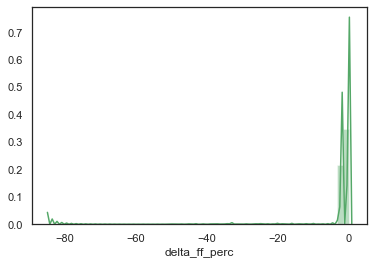

In [180]:
sns.set(style='white') # style = ['whitegrid', 'darkgrid', 'white', 'dark']
sns.distplot(speeds['delta_ff_perc'], color='g')

In [31]:
breaks = [10, 15, 20, 25, 30, 40]

In [183]:
import branca
import math

def style_function(feature):
    return {
        'fillOpacity': 0.5,
        'weight': 3,#math.log2(feature['properties']['speed'])*2,
        'color': colorscale(feature['properties']['delta_ff_perc'])
    }

index = breaks

colors = ['#d73027','#fc8d59','#fee090','#d8daeb','#998ec3','#542788']

#browns '#b35806','#f1a340','#fee0b6'
#reds '#d73027','#fc8d59','#fee090'
#blues '#e0f3f8','#91bfdb','#4575b4'
#purples ,'#d8daeb','#998ec3','#542788'
colorscale = branca.colormap.StepColormap(colors,
                                          index = index, caption='Average speeds per segment')

# weight = [1,2,3,4,5,6]
# weightscale = branca.colormap.StepColormap(weight,
#                                           index = index, caption='Santi')

m = folium.Map(location=[lat, lon], tiles='cartodbpositron', zoom_start=12)

folium.GeoJson(geo_data, 
               style_function = style_function,
               tooltip = folium.features.GeoJsonTooltip(fields=['segment_name','delta_ff_perc'],
                                              aliases = ['Segment', 'kmh = '],
                                              labels=True,
                                              sticky=False
                                             )).add_to(m)
m.save('speed-map-turku.html')

In [184]:
# We can try to get the average per segment

avg = speeds.pivot_table(['avg_speed', 'free_flow','delta_ff_perc'],
                     index=['segment_id', 'segment_name'],
                     aggfunc = 'mean').reset_index()

avg = pd.merge(avg, speeds.loc[:,['segment_id','geometry']], left_on = 'segment_id', right_on = 'segment_id', how = 'left')
avg.drop_duplicates(subset=['segment_id', 'delta_ff_perc', 'segment_name'], keep='first', inplace=True)

data_avg = avg.drop('geometry', axis=1)
avg = gpd.GeoDataFrame(data = data_avg, geometry = avg.geometry)
avg.head()

,segment_id,segment_name,avg_speed,delta_ff_perc,free_flow,geometry
0,1000_1001,Takamaantie - Jäkäläpolku,20.0,0.0,20.0,"LINESTRING (22.27307 60.43091, 22.27303 60.430..."
1,1001_998,Jäkäläpolku - Ispoinen,35.0,-2.0,34.0,"LINESTRING (22.27119 60.42832, 22.27117 60.428..."
2,1003_1004,Konevarikko - Rieskalähteentie,41.0,0.0,41.0,"LINESTRING (22.25690 60.47546, 22.25686 60.475..."
3,1004_693,Rieskalähteentie - Laihasmäentie,21.0,0.0,21.0,"LINESTRING (22.26411 60.47068, 22.26409 60.470..."
4,1009_1011,Kanslerintie - Pansiontie,19.0,0.0,19.0,"LINESTRING (22.22203 60.44569, 22.22200 60.445..."


In [185]:
avg = avg.sort_values(by='delta_ff_perc', ascending=True)

geo_data = avg.__geo_interface__

import jenkspy
breaks = jenkspy.jenks_breaks(list(speeds['delta_ff_perc']), nb_class=5)
breaks

[-84.0, -43.0, -27.0, -11.0, -2.0, 0.0]

In [186]:
avg.head(50)

,segment_id,segment_name,avg_speed,delta_ff_perc,free_flow,geometry
6636,T1_148,Kauppatori - Posti,4.000000,-60.000000,10.000000,"LINESTRING (22.26753 60.45004, 22.26751 60.450..."
1235,2052_2117,Keo - Kauppakeskus Mylly,18.000000,-58.000000,43.000000,"LINESTRING (22.16783 60.48723, 22.16768 60.487..."
240,117_1050,Aninkaistensilta - Yrjänänaukio,19.000000,-52.000000,40.000000,"LINESTRING (22.26782 60.45834, 22.26782 60.458..."
4065,6093_6095,Hakaniitty - Uusi Littoistentie,8.000000,-50.000000,16.000000,"LINESTRING (22.37895 60.44581, 22.37895 60.445..."
498,139_75,Urheilupuisto - Tiilentekijänkatu,13.000000,-50.000000,26.000000,"LINESTRING (22.26147 60.43936, 22.26147 60.439..."
1390,2121_2123,Itäniityntie - Metsärannantie,26.500000,-46.000000,49.000000,"LINESTRING (22.21151 60.49027, 22.21152 60.490..."
1393,2122_2145,Itäniityntie - Peltopohjankatu,22.000000,-42.000000,38.000000,"LINESTRING (22.21012 60.48953, 22.21009 60.489..."
2350,3159_3297,Salonkyläntie - Tammihaantie,23.000000,-42.000000,40.000000,"LINESTRING (21.95292 60.35863, 21.95280 60.358..."
2631,354_1681,Skanssinkatu - Hautausmaantie,22.000000,-42.000000,38.000000,"LINESTRING (22.31922 60.42987, 22.31935 60.429..."
106,103_157,Tiilentekijänkatu - Urheilupuisto,17.000000,-41.000000,29.000000,"LINESTRING (22.25559 60.43867, 22.25559 60.438..."


In [187]:
avg.tail()

,segment_id,segment_name,avg_speed,delta_ff_perc,free_flow,geometry
2784,395_1417,Erikvalla - Anttila,25.00,0.0,25.00,"LINESTRING (22.11385 60.35679, 22.11390 60.356..."
2783,394_1743,Friskalantie - Nuottakatu,33.00,0.0,33.00,"LINESTRING (22.23631 60.39939, 22.23632 60.399..."
2765,391_392,Suvilinnantie - Haarla,23.75,0.0,23.75,"LINESTRING (22.22065 60.39123, 22.22073 60.391..."
2702,379_1756,Brinkhallintie - Kakskerran koulu,60.00,0.0,60.00,"LINESTRING (22.17578 60.35899, 22.17577 60.359..."
3048,477_964,Pirttilähteenkatu - Kustavintie,12.00,0.0,12.00,"LINESTRING (22.22585 60.46861, 22.22582 60.468..."


In [191]:
breaks

[-84.0, -43.0, -27.0, -11.0, -2.0, 0.0]

In [194]:
import branca
import math

def style_function(feature):
    return {
        'fillOpacity': 0.5,
        'weight': 3,#feature['properties']['speed']*3/40 + 3,
        'color': colorscale(feature['properties']['delta_ff_perc'])
    }

index = [-84.0, -40.0, -30,-20.0, -10.0, 0.0]

colors = ['#d73027' ,'#fc8d59' ,'#fee090','#e0f3f8','#91bfdb','#4575b4']

#browns '#b35806','#f1a340','#fee0b6'
#reds '#d73027','#fc8d59','#fee090'
#blues '#e0f3f8','#91bfdb','#4575b4'
#purples ,'#d8daeb','#998ec3','#542788'


colorscale = branca.colormap.StepColormap(colors,
                                          index = index, caption='Average speeds per segment')

# weight = [1,2,3,4,5,6]
# weightscale = branca.colormap.StepColormap(weight,
#                                           index = index, caption='Santi')

m = folium.Map(location=[lat, lon], tiles='cartodbpositron', zoom_start=12)

folium.GeoJson(geo_data, 
               style_function = style_function,
               tooltip = folium.features.GeoJsonTooltip(fields=['segment_name','delta_ff_perc'],
                                              aliases = ['Segment', '% from free-flow = '],
                                              labels=True,
                                              sticky=False
                                             )).add_to(m)

m.save('average-speed-map-turku.html')

In [195]:
lat,lon

(60.41308000000001, 22.288812)

In [190]:
import keplergl as kp

m=kp.KeplerGl(height=600)
m.add_data(avg, name='% from Free-Flow per segment')
m

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'% from Free-Flow per segment': {'index': [6636, 1235, 240, 4065, 498, 1390, 1393, 2350, 2631, …

In [ ]:
# Save it as shapefile
prj = 'GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]'

avg.to_file(driver = 'ESRI Shapefile',
                filename = '/Users/santi/Google Drive/Master/Python/alightings from boardings/3- Load/Speeds/turku_average_speed.shp',
                encoding='utf-8',
                crs_wkt=prj)

In [ ]:
# m1 = folium.Map(location=[lat, lon], tiles='cartodbpositron', zoom_start=12)

# folium.GeoJson(gdf.__geo_interface__).add_to(m1)

# m1.save('gdf.html')

In [ ]:
# import pandas_profiling

# pandas_profiling.ProfileReport(speeds.drop('geometry',axis=1))